CSC 30100  
Project  
Leji Li  

In [1]:
import struct
import gzip
import math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
%matplotlib inline

In [2]:
train = dict()
test = dict()

In [3]:
def get_images(filename):
    with gzip.GzipFile(Path('mnist', filename), 'rb') as f:
        magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
        print(magic, size, rows, cols)
        images = np.frombuffer(f.read(), dtype= np.dtype('B'))
    return images.reshape(size, rows, cols)

In [4]:
def get_labels(filename):
    with gzip.GzipFile(Path('mnist', filename), 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype= np.dtype('B'))
    return labels

In [5]:
train['image'] = get_images('train-images-idx3-ubyte.gz')
test['image'] = get_images('t10k-images-idx3-ubyte.gz')
print(train['image'].shape, test['image'].shape)

2051 60000 28 28
2051 10000 28 28
(60000, 28, 28) (10000, 28, 28)


In [6]:
train['label'] = get_labels('train-labels-idx1-ubyte.gz')
test['label'] = get_labels('t10k-labels-idx1-ubyte.gz')
print(train['label'].shape, test['label'].shape)

(60000,) (10000,)


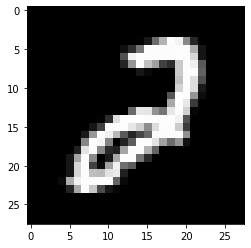

In [7]:
fig, ax = plt.subplots()
_ = ax.imshow(train['image'][555], cmap = 'gray')

In [8]:
np.unique(train['label'])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [9]:
train_2D = [[],[],[],[],[],[],[],[],[],[]]
test_2D = []
np.random.seed(42)
for i in range(len(train['image'])):
    temp = train['image'][i].flatten()
    temp = np.append(temp, [1])
    train_2D[train['label'][i]].append(temp)
for i in range(len(test['image'])):
    temp = test['image'][i].flatten()
    temp = np.append(temp, [1])
    test_2D.append(temp)

In [10]:
def get_digit_matrix(target_digit):
    length = len(train['image'])
    matrix = []
    ys = []
    matrix += train_2D[target_digit]
    ys = [1] * len(matrix)
    
    upper = round(len(ys) * 1 / 9)
    for i in range(upper):
        for j in range(10):
            if(j != target_digit):
                ran = np.random.randint(len(train_2D[j]))
                temp = train_2D[j][ran]
                matrix.append(temp)
                ys.append(-1)
                
    return matrix, ys

***Part 1***

In [11]:
def getBeta(target_digit):
    
    zeros = np.array([0] * 785)
    zs = []
    matrix, ys = get_digit_matrix(target_digit)
    
    for xi in matrix:
        zeros += xi
    
    # find the 0s
    for i in range(len(zeros)):
        if(zeros[i] == 0):
            zs.append(i)
    # get the beta
    np_matrix = np.array(matrix)
    np_matrix = np.delete(np_matrix, zs, axis = 1) # take the 0s out
    np_ys = np.array(ys) #here's the b
    beta = np.linalg.lstsq(np_matrix, np_ys, rcond = None)[0] # solving LS
    # put 0s back
    for i in zs:
        beta = np.insert(beta, i, 0)
    return beta

In [12]:
def calculate_error(beta, target_digit):
    hit_error = 0  # record the amount that doesn't recognize the target digit
    hit = 0        # record the amount that successfully recognize the target digit
    miss_error = 0 # record the amount that mis-recognize other digits
    miss = 0       # record the amount that not recognizing other digits
    two_total = 0
    length = len(test['label'])
    res = [0] * 10
    res_err = [0] * 10
    for i in range(length):
        test_image = test_2D[i]
        y = np.dot(test_image, beta)
        if(test['label'][i] == target_digit):
            two_total += 1
            if(y < 0):
                hit_error += 1
                res_err[target_digit] += 1
            else:
                hit += 1
                res[target_digit] += 1
        else:
            if(y >= 0):
                miss_error += 1
                res[test['label'][i]] += 1
            else:
                miss += 1
                res_err[test['label'][i]] += 1
    #print("Total images that is", target_digit, ":", two_total)
    #print("Image is", target_digit, "and recognized:", hit)
    #print("Image is", target_digit, "but didn't hit:", hit_error)
    #print("Other images:", (len(test['label']) - two_total))
    #print("Image isn't", target_digit, "and skipped:", miss)
    #print("Image isn't", target_digit, "but recognized:", miss_error)
    
    err_sum = 0
    print("Target is", target_digit)
    for i in range(10):
        if(i == target_digit):
            err_sum += res_err[i]
        else:
            err_sum += res[i]
        print("{0:d} -> recognized: {1:<5d} | not: {2:<5d}".format(i, res[i], res_err[i]))
    print("Total correctness:", "{:.2f}".format((100*(length - err_sum)/length)), "%")
    print("-----------------------------------------")

In [13]:
def draw_beta(beta):
    beta = np.delete(beta, len(beta) -1)
    
    fig, ax = plt.subplots()
    _ = ax.imshow(beta.reshape(28, 28), cmap = 'gray')

In [14]:
betas = []
for i in range(10):
    betas.append(getBeta(i))

In [15]:
for i in range(10):
    calculate_error(betas[i], i)

Target is 0
0 -> recognized: 968   | not: 12   
1 -> recognized: 0     | not: 1135 
2 -> recognized: 48    | not: 984  
3 -> recognized: 36    | not: 974  
4 -> recognized: 4     | not: 978  
5 -> recognized: 47    | not: 845  
6 -> recognized: 52    | not: 906  
7 -> recognized: 29    | not: 999  
8 -> recognized: 15    | not: 959  
9 -> recognized: 14    | not: 995  
Total correctness: 97.43 %
-----------------------------------------
Target is 1
0 -> recognized: 1     | not: 979  
1 -> recognized: 1123  | not: 12   
2 -> recognized: 117   | not: 915  
3 -> recognized: 23    | not: 987  
4 -> recognized: 30    | not: 952  
5 -> recognized: 22    | not: 870  
6 -> recognized: 20    | not: 938  
7 -> recognized: 51    | not: 977  
8 -> recognized: 71    | not: 903  
9 -> recognized: 10    | not: 999  
Total correctness: 96.43 %
-----------------------------------------
Target is 2
0 -> recognized: 40    | not: 940  
1 -> recognized: 77    | not: 1058 
2 -> recognized: 945   | not: 87  

***Part 2***

In [16]:
def get_beta_lambda(target_digit_matrix, y_matrix, lamb):
    matrix = []
    ys = []
    for i in range(784):
        temp = [0] * 785
        temp[i] = math.sqrt(lamb)
        matrix.append(np.array(temp))
        ys.append(0)
    matrix += target_digit_matrix
    ys += y_matrix
    np_matrix = np.array(matrix)
    np_ys = np.array(ys)
    beta = np.linalg.lstsq(np_matrix, np_ys, rcond = None)[0]
    return beta

In [17]:
def get_norms(target_matrix, y_matrix, beta):
    r = np.matmul(target_matrix, beta) - y_matrix
    r_norm = np.linalg.norm(r)
    b = beta[:-1]
    beta_norm = np.linalg.norm(b)
    return r_norm, beta_norm

In [18]:
target = 0
target_matrix, y_matrix = get_digit_matrix(target)
betas_2 = []
lambs = []
index = []
for i in range(0, 12):
    index.append(i)
    lambs.append(10**i)
    betas_2.append(get_beta_lambda(target_matrix, y_matrix, 10**i))
r_norms = []
b_norms = []
for b in betas_2:
    r_n, b_n = get_norms(target_matrix, y_matrix, b)
    r_norms.append(r_n)
    b_norms.append(b_n)

Text(0.5, 0, '$||\\hat{y} - y||_2$')

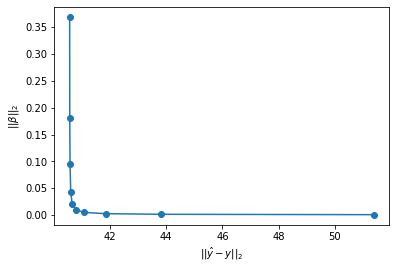

In [19]:
plt.plot(r_norms[0:10], b_norms[0:10], marker='o')
plt.ylabel(r'$||\beta||_2$')
plt.xlabel(r'$||\hat{y} - y||_2$')

In [20]:
print("We can use the lambda =", lambs[5])

We can use the lambda = 100000


From the graph above, we can see that after the 6th point, the solution norm is not changing as rapidly as the previous points. So we can consider the 6th $\lambda$ is good enough.

In [21]:
print("Good enough lambda")
calculate_error(betas_2[5], 0)

Good enough lambda
Target is 0
0 -> recognized: 969   | not: 11   
1 -> recognized: 0     | not: 1135 
2 -> recognized: 49    | not: 983  
3 -> recognized: 36    | not: 974  
4 -> recognized: 5     | not: 977  
5 -> recognized: 42    | not: 850  
6 -> recognized: 43    | not: 915  
7 -> recognized: 21    | not: 1007 
8 -> recognized: 15    | not: 959  
9 -> recognized: 14    | not: 995  
Total correctness: 97.64 %
-----------------------------------------


In [22]:
for i in range(len(betas_2)):
    print("the", i+1, "lambda:")
    calculate_error(betas_2[i], 0)

the 1 lambda:
Target is 0
0 -> recognized: 969   | not: 11   
1 -> recognized: 0     | not: 1135 
2 -> recognized: 50    | not: 982  
3 -> recognized: 39    | not: 971  
4 -> recognized: 5     | not: 977  
5 -> recognized: 39    | not: 853  
6 -> recognized: 45    | not: 913  
7 -> recognized: 32    | not: 996  
8 -> recognized: 16    | not: 958  
9 -> recognized: 16    | not: 993  
Total correctness: 97.47 %
-----------------------------------------
the 2 lambda:
Target is 0
0 -> recognized: 969   | not: 11   
1 -> recognized: 0     | not: 1135 
2 -> recognized: 52    | not: 980  
3 -> recognized: 39    | not: 971  
4 -> recognized: 4     | not: 978  
5 -> recognized: 39    | not: 853  
6 -> recognized: 45    | not: 913  
7 -> recognized: 32    | not: 996  
8 -> recognized: 16    | not: 958  
9 -> recognized: 16    | not: 993  
Total correctness: 97.46 %
-----------------------------------------
the 3 lambda:
Target is 0
0 -> recognized: 969   | not: 11   
1 -> recognized: 0     | not

We can see that the correctness rate is increasing from the first $\lambda$ and reach the highest at the 8th $\lambda$, which indicate that the 8th $\lambda$ will be the best solution. After the 8th point, the correctness rate is dropping rapidly.

In [23]:
print("result of part 1")
calculate_error(betas[0], 0)

result of part 1
Target is 0
0 -> recognized: 968   | not: 12   
1 -> recognized: 0     | not: 1135 
2 -> recognized: 48    | not: 984  
3 -> recognized: 36    | not: 974  
4 -> recognized: 4     | not: 978  
5 -> recognized: 47    | not: 845  
6 -> recognized: 52    | not: 906  
7 -> recognized: 29    | not: 999  
8 -> recognized: 15    | not: 959  
9 -> recognized: 14    | not: 995  
Total correctness: 97.43 %
-----------------------------------------


Comparing with the beta from part 1, the good enough beta works slightly better.

***Part 3***

In [24]:
from sklearn.preprocessing import StandardScaler


In [25]:
target = train_2D[0]
target = np.delete(target, len(target[0]) - 1, axis = 1)
target = StandardScaler().fit_transform(target)

In [26]:
cov = np.cov(target.T)

In [27]:
eig_vals, eig_vecs = np.linalg.eig(cov)

In [28]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

In [29]:
eig_pairs.sort(key = lambda x: x[0], reverse = True)

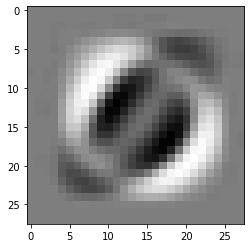

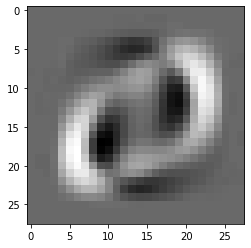

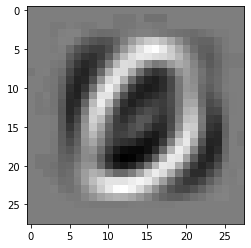

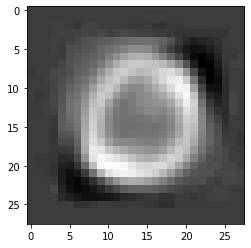

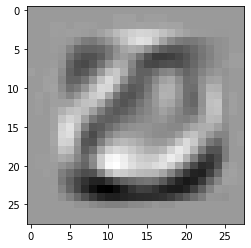

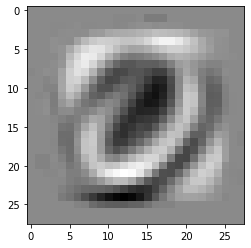

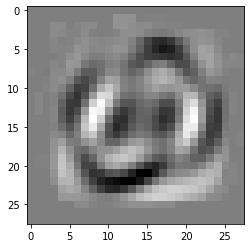

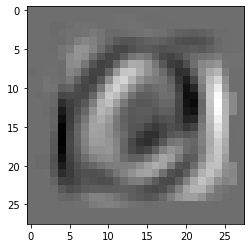

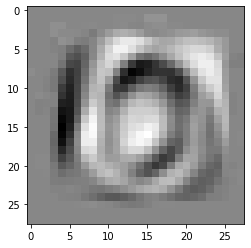

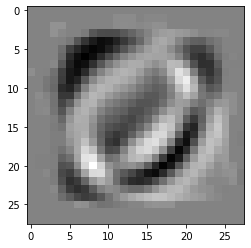

In [30]:
for i in range(10):
    temp = []
    for c in eig_pairs[i][1]:
        temp.append(c.real)
    temp = np.array(temp)
    fig, ax = plt.subplots()
    _ = ax.imshow(temp.reshape(28, 28), cmap = 'gray')

***4***

In [31]:
# because the jacobian matrix is not changing according to the x
# make is global s.t. wouldn't calcuate it every time it was called
phi_Xs = []
yys = []

In [32]:
# calculate the phi x
def get_phi(x, k):
    ekx = math.exp(k*x)
    return (ekx)/(1+ekx)

In [33]:
# convert the image matrix to phi(x)
def get_phi_xs(matrix, k):
    temp = []
    for row in matrix:
        row_temp = []
        for i in range(len(row) - 1):
            row_temp.append(get_phi(row[i], k))
        row_temp.append(1)
        temp.append(np.array(row_temp))
    temp = np.array(temp)
    return temp

In [34]:
# function for getting the jacobian matrix
# use for the calling of build-in least_squares function
def get_jac(x):
    global phi_Xs
    return phi_Xs

In [35]:
# convert the ys from [-1,1] to [0,1]
def get_yys(ys):
    temp = []
    for y in ys:
        if (y == 1):
            temp.append(1)
        else:
            temp.append(0)
    return np.array(temp)

In [36]:
# the function phi(x)*beta - y
# the parameter x here is the beta
def get_func(x):
    global phi_Xs
    global yys
    temp = []
    for i in range(len(phi_Xs)):
        row = phi_Xs[i]
        y = yys[i]
        prod = np.dot(row, x)
        temp.append(prod - y)
    return np.array(temp)

In [37]:
# exam how well is the beta
def calculate_error_k(beta, target_digit, k):
    hit_error = 0  # record the amount that doesn't recognize the target digit
    hit = 0        # record the amount that successfully recognize the target digit
    miss_error = 0 # record the amount that mis-recognize other digits
    miss = 0       # record the amount that not recognizing other digits
    two_total = 0
    length = len(test['label'])
    res = [0] * 10
    res_err = [0] * 10
    test_2D_k = get_phi_xs(test_2D, k)
    for i in range(length):
        test_image = test_2D_k[i]
        y = np.dot(test_image, beta)
        if(test['label'][i] == target_digit):
            two_total += 1
            if(y < k/2):
                hit_error += 1
                res_err[target_digit] += 1
            else:
                hit += 1
                res[target_digit] += 1
        else:
            if(y >= k/2):
                miss_error += 1
                res[test['label'][i]] += 1
            else:
                miss += 1
                res_err[test['label'][i]] += 1
    
    err_sum = 0
    print("Target is", target_digit)
    for i in range(10):
        if(i == target_digit):
            err_sum += res_err[i]
        else:
            err_sum += res[i]
        print("{0:d} -> recognized: {1:<5d} | not: {2:<5d}".format(i, res[i], res_err[i]))
    print("Total correctness:", "{:.2f}".format((100*(length - err_sum)/length)), "%")
    print("-----------------------------------------")

In [38]:
# get the beta
def get_beta_k(matrix, k):
    global phi_Xs
    global yys
    index = []
    zeros = np.array([0] * 785, dtype = "float64")
    for row in matrix:
        zeros += row
    for i in range(len(zeros)):
        if(zeros[i] == 0):
            index.append(i)
    matrix = np.delete(matrix, index, axis = 1)
    phi_Xs = get_phi_xs(matrix, k)
    initial_guess = np.array([0]*len(phi_Xs[0]))
    res = least_squares(get_func, initial_guess, get_jac)
    beta = res.x
    for i in index:
        beta = np.insert(beta, i, 0)
    return beta

In [39]:
# main entriance of part 4
betas_k = []
for k in [1, 1.2]:
    matrix, ys = get_digit_matrix(0)
    yys = get_yys(ys)
    betas_k.append(get_beta_k(matrix, k))

In [40]:
ks = [1, 1.2]
for i in range(len(betas_k)):
    calculate_error_k(betas_k[i], 0, ks[i])

Target is 0
0 -> recognized: 967   | not: 13   
1 -> recognized: 0     | not: 1135 
2 -> recognized: 44    | not: 988  
3 -> recognized: 30    | not: 980  
4 -> recognized: 1     | not: 981  
5 -> recognized: 43    | not: 849  
6 -> recognized: 56    | not: 902  
7 -> recognized: 27    | not: 1001 
8 -> recognized: 17    | not: 957  
9 -> recognized: 19    | not: 990  
Total correctness: 97.50 %
-----------------------------------------
Target is 0
0 -> recognized: 956   | not: 24   
1 -> recognized: 0     | not: 1135 
2 -> recognized: 18    | not: 1014 
3 -> recognized: 15    | not: 995  
4 -> recognized: 1     | not: 981  
5 -> recognized: 14    | not: 878  
6 -> recognized: 31    | not: 927  
7 -> recognized: 18    | not: 1010 
8 -> recognized: 7     | not: 967  
9 -> recognized: 8     | not: 1001 
Total correctness: 98.64 %
-----------------------------------------


In [41]:
print("result of part 1")
calculate_error(betas[0], 0)

result of part 1
Target is 0
0 -> recognized: 968   | not: 12   
1 -> recognized: 0     | not: 1135 
2 -> recognized: 48    | not: 984  
3 -> recognized: 36    | not: 974  
4 -> recognized: 4     | not: 978  
5 -> recognized: 47    | not: 845  
6 -> recognized: 52    | not: 906  
7 -> recognized: 29    | not: 999  
8 -> recognized: 15    | not: 959  
9 -> recognized: 14    | not: 995  
Total correctness: 97.43 %
-----------------------------------------


In [42]:
jac_lamb = []
phi_xs_lamb = []
ys_lamb = []

In [43]:
def get_func_lamb(x):
    global jac_lamb
    temp = []
    for i in range(len(jac_lamb)):
        row = np.dot(jac_lamb[i], x)
        temp.append(row-ys_lamb[i])
    return np.array(temp)

In [44]:
def get_jac_lamb(x):
    global jac_lamb
    return jac_lamb

In [45]:
def get_matrixs_k_lamb(target_matrix, y_matrix, lamb):
    global jac_lamb
    global phi_xs_lamb
    global ys_lamb
    matrix = []
    ys = []
    for i in range(784):
        temp = [0] * 785
        temp[i] = math.sqrt(lamb)
        matrix.append(np.array(temp))
        ys.append(0)
    matrix = np.array(matrix)
    ys = np.array(ys)
    yys = get_yys(y_matrix)
    jac_lamb = np.vstack((matrix, phi_xs_lamb))
    ys_lamb = np.append(ys, yys)

In [46]:
def get_beta_k_lamb():
    initial_guess = np.array([0] * 785)
    res = least_squares(get_func_lamb, initial_guess, get_jac_lamb)
    return res.x

In [47]:
def get_norms_k_lamb(beta):
    r = np.matmul(jac_lamb, beta) - ys_lamb
    r_norm = np.linalg.norm(r)
    b = beta[:-1]
    beta_norm = np.linalg.norm(b)
    return r_norm, beta_norm

In [48]:
k = 1
target_matrix, y_matrix = get_digit_matrix(0)
phi_xs_lamb = get_phi_xs(target_matrix, k)
betas_k_lamb = []
for lamb in range(0, 10):
    get_matrixs_k_lamb(target_matrix, y_matrix, lamb)
    beta = get_beta_k_lamb()
    betas_k_lamb.append(beta)

In [49]:
r_norms_k = []
b_norms_k = []
for b in betas_k_lamb:
    rnk, bnk = get_norms_k_lamb(b)
    r_norms_k.append(rnk)
    b_norms_k.append(bnk)

In [50]:
print(" y^-y | beta  ")
print("--------------")
for i in range(len(r_norms_k)):
    print("{:>5.2f} | {:>5.2f}".format(r_norms_k[i], b_norms_k[i]))

 y^-y | beta  
--------------
35.83 | 10.06
20.01 |  1.63
19.83 |  1.31
19.77 |  1.17
19.75 |  1.08
19.73 |  1.02
19.72 |  0.98
19.72 |  0.95
19.72 |  0.92
19.72 |  0.90


Text(0.5, 0, '$||\\hat{y} - y||_2$')

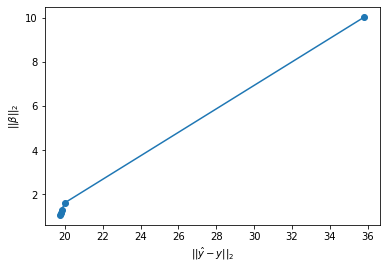

In [51]:
plt.plot(r_norms_k[:5], b_norms_k[:5], marker='o')
plt.ylabel(r'$||\beta||_2$')
plt.xlabel(r'$||\hat{y} - y||_2$')

In [56]:
print("When lambda = 4")
calculate_error_k(betas_k_lamb[4], 0, k)

When lambda = 4
Target is 0
0 -> recognized: 970   | not: 10   
1 -> recognized: 1     | not: 1134 
2 -> recognized: 44    | not: 988  
3 -> recognized: 31    | not: 979  
4 -> recognized: 2     | not: 980  
5 -> recognized: 38    | not: 854  
6 -> recognized: 47    | not: 911  
7 -> recognized: 23    | not: 1005 
8 -> recognized: 12    | not: 962  
9 -> recognized: 19    | not: 990  
Total correctness: 97.73 %
-----------------------------------------


In [53]:
print("Patr 2, when lambda = 7")
calculate_error(betas_2[7], 0)

Patr 2, when lambda = 7
Target is 0
0 -> recognized: 969   | not: 11   
1 -> recognized: 0     | not: 1135 
2 -> recognized: 47    | not: 985  
3 -> recognized: 33    | not: 977  
4 -> recognized: 3     | not: 979  
5 -> recognized: 43    | not: 849  
6 -> recognized: 41    | not: 917  
7 -> recognized: 19    | not: 1009 
8 -> recognized: 16    | not: 958  
9 -> recognized: 14    | not: 995  
Total correctness: 97.73 %
-----------------------------------------
